In [1]:
import zipfile
import matplotlib.pyplot as plt
from pykml import parser
import pandas as pd
import xml.dom.minidom
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import radians, cos, sin, asin, sqrt
import math
import numpy as np

In [2]:
def read_kmz(infile):
    """read raw kml/kmz file"""
    if infile.upper().endswith('.KML'):    
        with open(infile, "r") as f:
            return f.read()

    if infile.upper().endswith('.KMZ'):
        with zipfile.ZipFile(infile, "r") as f:
            return f.read(f.namelist()[0])

In [3]:
filename=r'C:/Users/Vladislav/Desktop/Диск/Мои доки/Личное/PYTHON/Test_Route_SE/Test_Route_SE/task_2_sensor.kml'

rawkml = read_kmz(filename)

soup = BeautifulSoup(rawkml,'html.parser')
placemarks = soup.find_all('placemark')

print(placemarks)

[<placemark>
<visibility>0</visibility>
<open>0</open>
<styleurl>#red</styleurl>
<name></name>
<description>
 - Track no. 1</description>
<linestring>
<extrude>true</extrude>
<tessellate>true</tessellate>
<altitudemode>clampToGround</altitudemode>
<coordinates>
                            13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323018,52.499687,0 13.323

C:\Users\Vladislav\anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


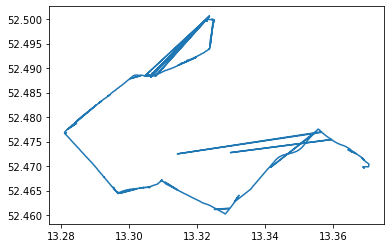

In [4]:
for x in (placemarks[0].select_one('coordinates')):
    coordinates_list = x.split()

latitude = []
longtitude = []
for x in coordinates_list:
    lat = x.split(',')[1]
    long = x.split(',')[0]
    
    latitude.append(float(lat))
    longtitude.append(float(long))

fig = plt.plot(longtitude,latitude)
plt.show()

In [5]:
df = pd.DataFrame({'latitude':latitude, 'longtitude': longtitude})

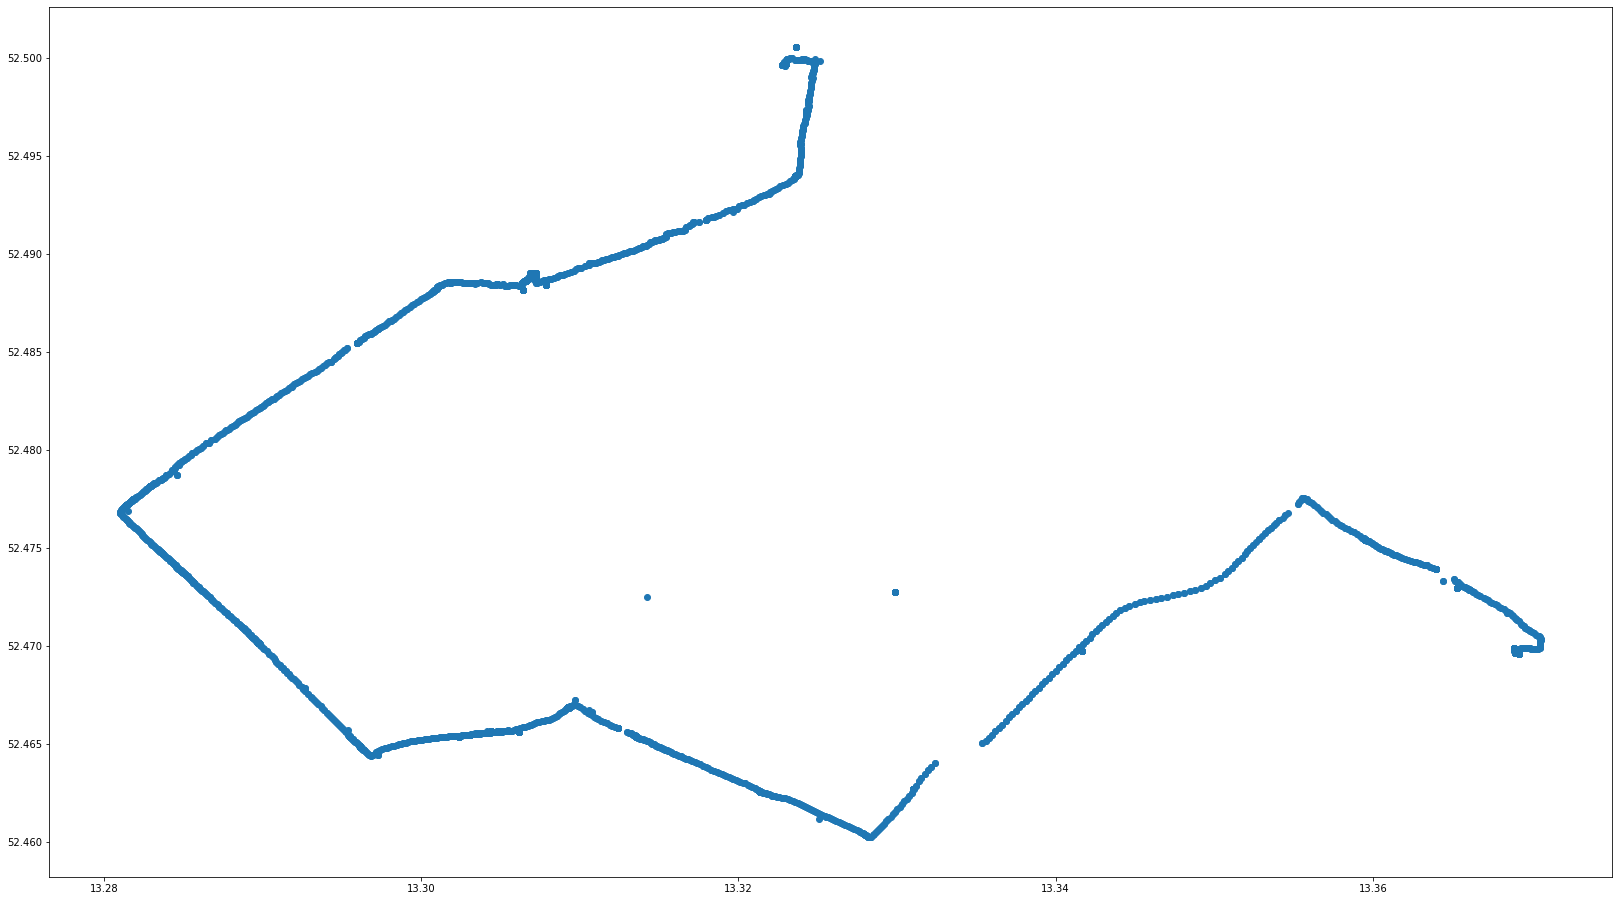

In [6]:
plt.figure(figsize=(28, 16))
plt.scatter(longtitude, latitude)

In [7]:
def distance(llat1, llongt1, llat2, llongt2):
    #pi - число pi, rad - радиус сферы (Земли)
    rad = 6372795

    #в радианах
    lat1 = llat1*math.pi/180.
    lat2 = llat2*math.pi/180.
    long1 = llongt1*math.pi/180.
    long2 = llongt2*math.pi/180.

    #косинусы и синусы широт и разницы долгот
    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)

    #вычисления длины большого круга
    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)
    dist = ad*rad

    return dist

In [8]:
dist = []

for i in range(len(df)):
    try:
        dist.append(distance(df.loc[i-1]['latitude'], df.loc[i-1]['longtitude'], df.loc[i]['latitude'], df.loc[i]['longtitude']))
    except:
        dist.append(0.0)
        
df.insert(2, 'dist', dist)

In [9]:
def purge_df(df):
    
    index_for_drop = []
    latitude_for_drop = []
    longtitude_for_drop = []

    for i in range(len(df)):
        if df.loc[i]['dist'] > 30:
            index_for_drop.append(i)
            latitude_for_drop.append(df.loc[i]['latitude'])
            longtitude_for_drop.append(df.loc[i]['longtitude'])
    
    purified_df = df.drop(index_for_drop)
    purified_df = purified_df.reset_index(drop=True)
    
    for i in range(len(latitude_for_drop)):
        purified_df_lat = purified_df[purified_df['latitude'] == latitude_for_drop[i]]
        purified_df_long = purified_df_lat[purified_df_lat['longtitude'] == longtitude_for_drop[i]]
        purified_df = purified_df.drop(purified_df_long.index)
    
    purified_df = purified_df.reset_index(drop=True)
    
    purified_df = purified_df.drop(columns=['dist'])
    purified_df = purified_df.drop_duplicates(subset=['latitude', 'longtitude'], keep='last')
    purified_df = purified_df.reset_index(drop=True)
    
    dist = []

    for i in range(len(purified_df)):
        try:
            dist.append(distance(purified_df.loc[i-1]['latitude'], purified_df.loc[i-1]['longtitude'], purified_df.loc[i]['latitude'], purified_df.loc[i]['longtitude']))
        except:
            dist.append(0.0)
    
    purified_df.insert(2, 'dist', dist)
    
    for i in dist:
        if i > 30:
            purge_df(purified_df)
        else:
            return(purified_df)

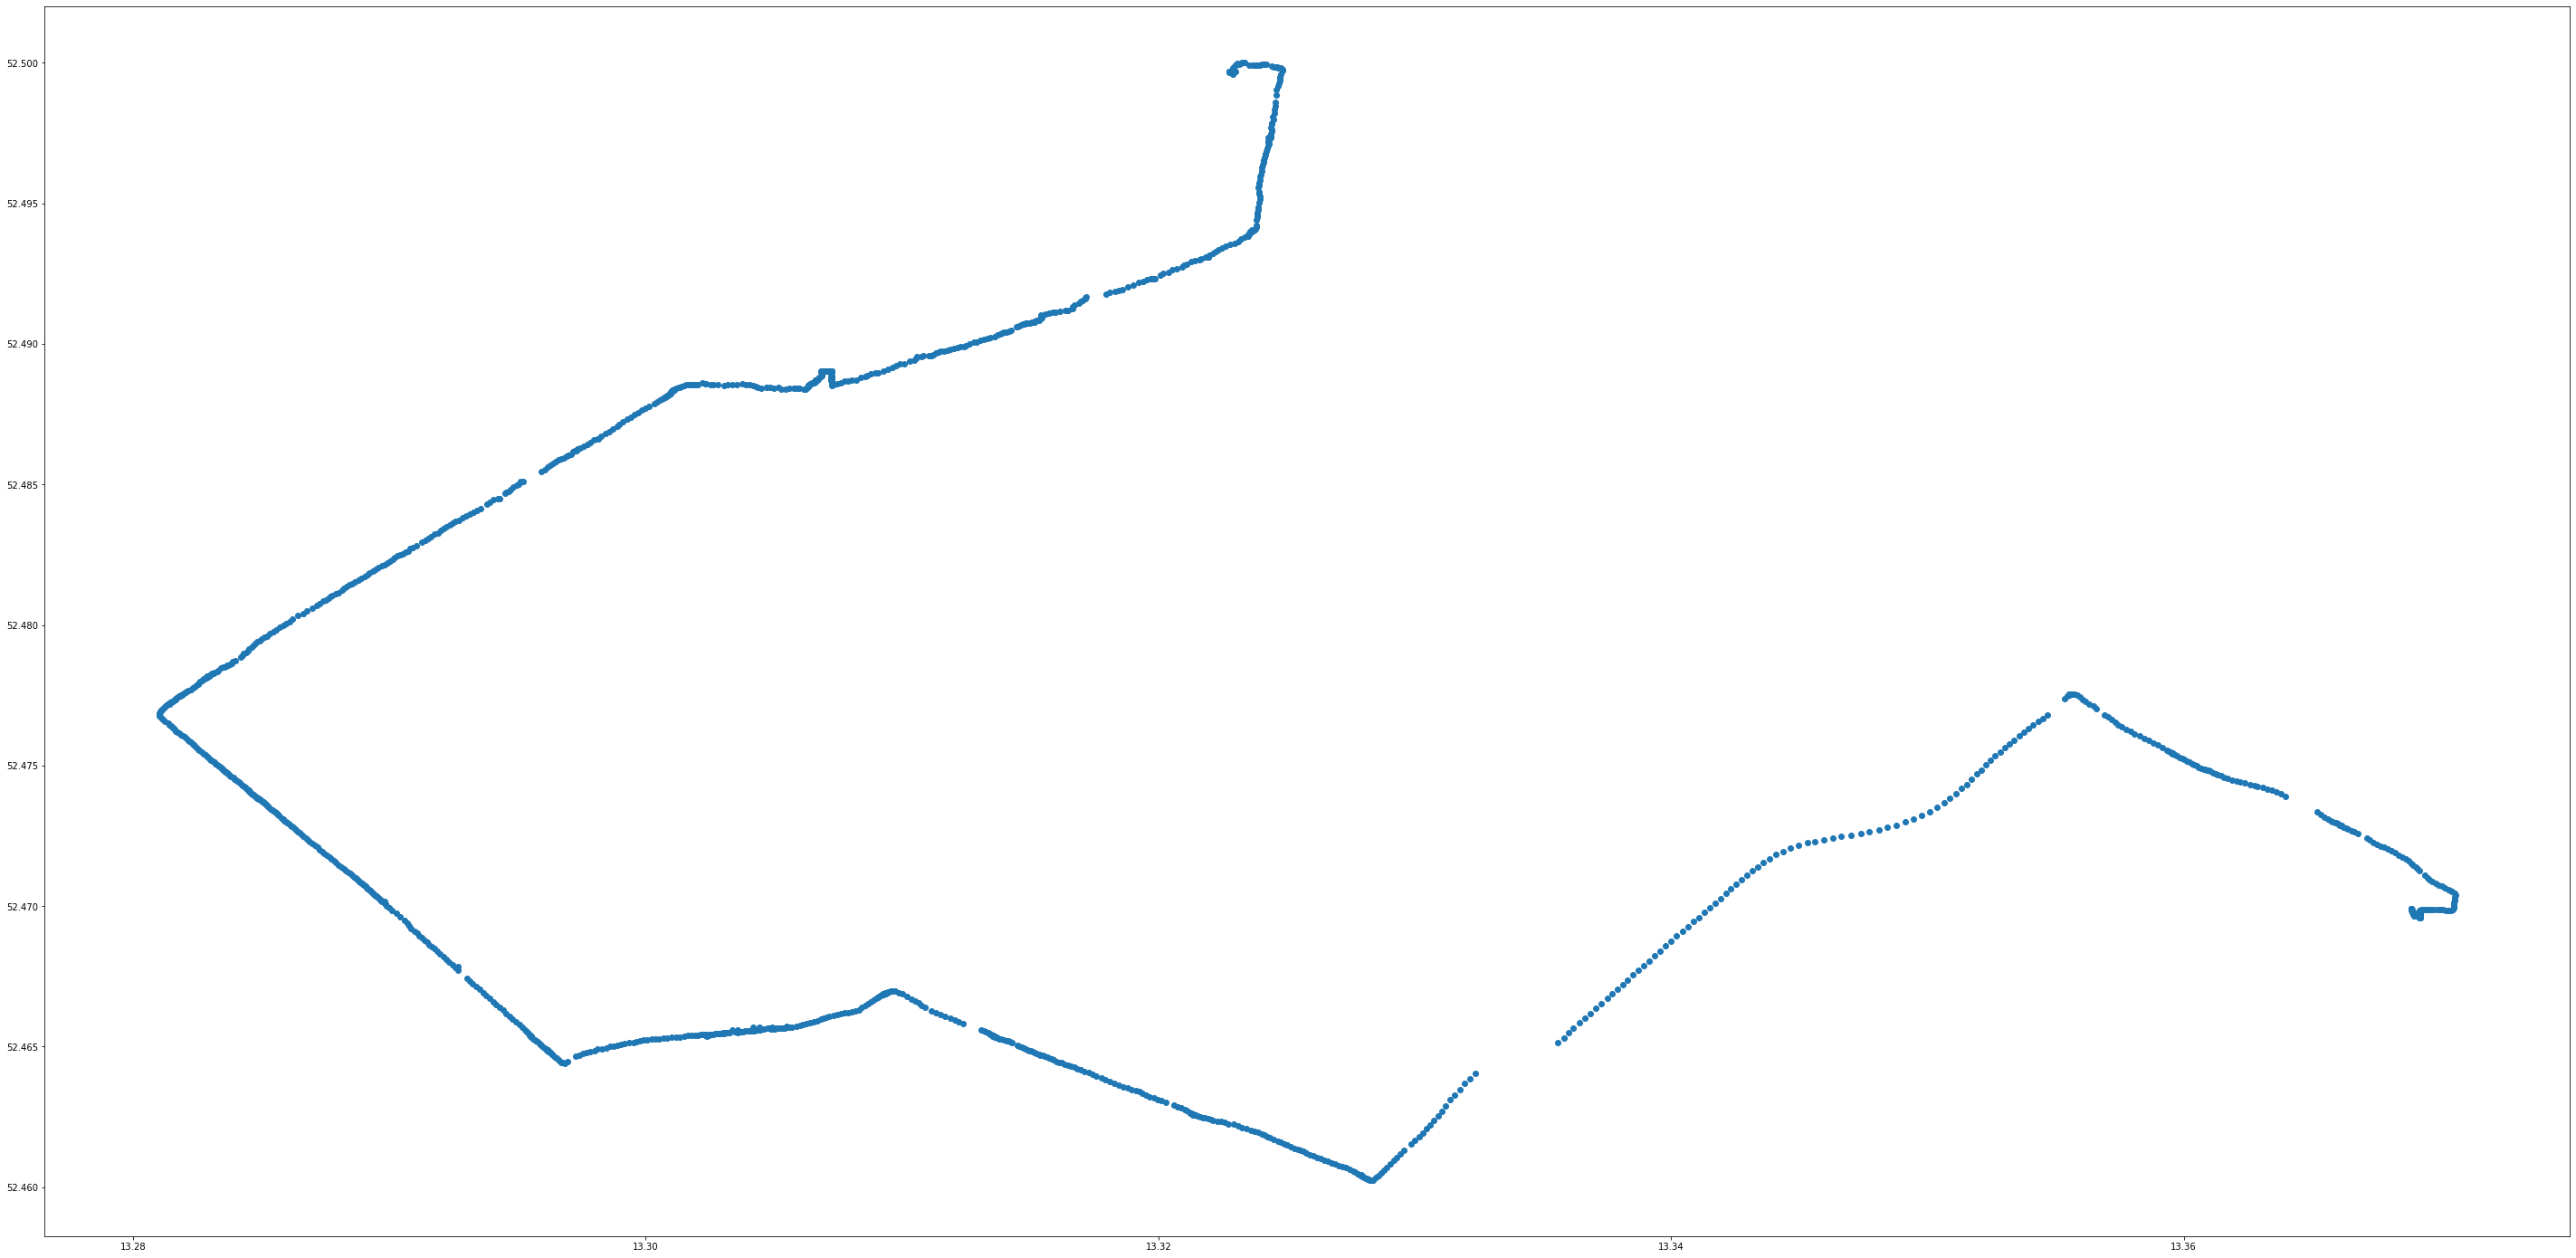

Total distance: 13.39 kilometres


In [11]:
purified_df = purge_df(df)
distance_total = purified_df['dist'].sum() / 1000

plt.figure(figsize=(50, 25))
# text = [str(i) for i in list(purified_df.index)]
plt.scatter(purified_df['longtitude'], purified_df['latitude'])

# for i in range(len(purified_df)):
#     plt.annotate(text[i], (purified_df.loc[i]['longtitude'], purified_df.loc[i]['latitude']))

plt.show()

print(f'Total distance: {distance_total.round(2)} kilometres.')